1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

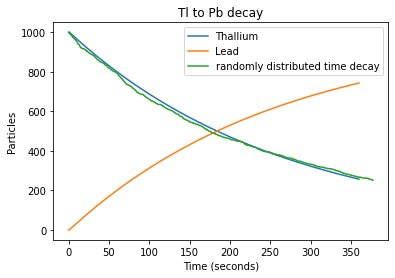

In [1]:
import numpy as np
import matplotlib.pyplot as plt

T = 6*60
tau = 3.052*60
_tau = tau/np.log(2)
p = lambda t: 1-2**(-t/tau)
# The inverted cumulative probability reads:
inv_p = lambda z: -_tau*np.log(1-z)


N = 1000
n = [N]
l = [0]

for t in range(T):
    loss = N*p(t)
    l.append(loss)
    n.append(N-loss)

plt.plot(n, label = 'Thallium')
plt.plot(l, label = 'Lead')

lived_until = [inv_p(np.random.random()) for _ in range(N)]
lived_until.sort()
alive = [N]
for _ in lived_until[:-1]:
    # Remove an atom for each instant
    alive.append(alive[-1]-1)


tc = int(3*len(alive)/4)
plt.title('Tl to Pb decay')
plt.xlabel('Time (seconds)')
plt.ylabel('Particles')
plt.plot(lived_until[:tc],alive[:tc], label = 'randomly distributed time decay')
plt.legend()
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [2]:
Z = 79
E = 7.7#MeV
a_0 = 5.5
e = np.sqrt(1.4399764)#sqrt(MeV*fm)
e_0 = 5.526*e**2#MeV^{-1}fm^{-1}
N = 1000000
sigma = a_0/100
theta = lambda b: 2*np.arctan(Z*e**2/(2*np.pi*e_0)*E*b)
b = lambda u: np.sqrt(-2*sigma**2*np.log(1-u))
t = theta(b(np.random.random(N)))
len(t[t>np.pi/2])/N

0.583372

3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [3]:
# We know that sin(z) for real z is at most 1. Therefore, the curve is bounded above by 1 and below by 0.
f = lambda x: np.sin(1/(x*(2-x)))**2
M = 1
m = 0
N = 100000
a = 0
b = 2

def hit_n_miss(f,a,b,M,m,N):
    '''Hit and miss method for one dimensional numerical integration.\n
    f: integrand function (float->float), a: lower limit (float), b: upper limit (float), M: f(x) upper bound (float), m: f(x) lower bound (float), N: sample size (int).'''
    A_0 = (M-m)*(b-a)
    x_sample = (b-a)*np.random.random(N)+a
    y_sample = (M-m)*np.random.random(N)+m
    curve = f(x_sample)
    below_f = y_sample[y_sample < curve]
    N_below = len(below_f)
    A = A_0*N_below/N
    return A

A = hit_n_miss(f,a,b,M,m,N)
print(f'Hit and miss area under the curve: {A}')
error = np.std([hit_n_miss(f,a,b,M,m,N) for _ in range(1000)])
print(f'Approximate error of {error}')

def mean_value(f,a,b,N, sampling = np.random.random):
    '''Non-weighted mean-value method for numerical integration.\n
    f: integrand function (float->float), a: lower limit (float), b: upper limit (float), N: sample size (int).'''
    x_sample = (b-a)*sampling(N)+a
    A = (b-a)/N*np.sum(f(x_sample))
    return A
A = mean_value(f,a,b,N)
print(f'Mean value area under the curve: {A}')
error = np.std([mean_value(f,a,b,N) for _ in range(1000)])
print(f'Approximate error of {error}')

Hit and miss area under the curve: 1.4503
Approximate error of 0.0027598737303724625
Mean value area under the curve: 1.450430453202909
Approximate error of 0.0016152768239006557


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [4]:
# We know beforehand we'll work with unit spheres, therefore, exploring from -1 to 1 for each variable should be enough.
a = -1
b = 1
N = 1000000
x_sample = a + (b-a)*np.random.random(N)
y_sample = a + (b-a)*np.random.random(N)
L = b-a
X = np.vstack([x_sample,y_sample])
# We exploit the fact f(x,y,...) is a binary function and simply transform the boolean-valued array into an integer-valued one.
h = lambda X: np.array(np.linalg.norm(X,axis=0)<=1,dtype= int)
A = np.sum(h(X))/N*L*L

print(A)

def any_d_sphere(R,D,N):
    a = -R
    b = R
    L = 2*R
    X = a +(b-a)*np.random.random(N)
    h = lambda X: np.array(np.linalg.norm(X,axis=0)<=R,dtype= int)
    for _ in range(D-1):
        x_n = a +(b-a)*np.random.random(N)
        X = np.vstack([X,x_n])
    return np.sum(h(X))/N*L**D
any_d_sphere(1,10,1000000)

3.139784


2.545664

5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [5]:
# The normalized density is:
w = lambda x: 1/(2*np.sqrt(x))
# With inverse cumulative:
inv_w = lambda z: z**2

# The function and its weighted version are:
f = lambda x: 1/(np.sqrt(x)*(np.exp(x)+1))
g = lambda x: f(x)/w(x)

# Sampler function:
sampler = lambda x: inv_w(np.random.random(x))

# Since the integral is from 0 to 1 and the density is normalized,
# the integral is simply:
I = mean_value(g,0,1,1000000,sampler)
I

0.8387493140506574